# Lab 7 - Infotaxis
(aka- pure curiosity-driven search)

Here we will explore how our little artificial organisms do two things:

1. Learn a *concept* of information as a signal. This reflects the curiosity about a signal, as opposed to its magnitude.
2. How this concept of information facilitates learning in noisy environments.

## Background

In this lab we return to _taxic explorations_. Recall that in Lab 4 (evidence accumulation) we look at what happens when sense information is not just noisy, but partially observed. In otherwords, when there is distortion in the channel of information.

Here we will compare the simple chemotaxic framework, where agents simply follow the gradient of the scent, to an _infotaxic_ framework where agents follow the _information_ carried in the signal instead.



Recall that our basic model of valentino exploration is as simple as can be.

- When the gradient is positive, meaning you are going "up" the gradient, the probability of turning is set to _p pos_.
- When the gradient is negative, the turning probability is set to _p neg_. (See code below, for an example).
- If the agent "decides" to turn, the direction it takes is uniform random.
- The length of travel before the next turn decision is sampled from an exponential distribution just like the _DiffusionDiscrete_

### Information agents
We will study three agents. One who does _chemotaxis_. One who does a kind of _infotaxis_. One that does random search (aka Diffusion). For fun, let's call this one a _randotaxis_ agent. This last rando-agent is really a control. A reference point.

In a sense the _chemotaxis_ agent only tries to answer question Q2 (above). While _infotaxis_ only tries to answer Q1. They are extreme strategies, in other words. The bigger question we will ask, in a very limited setting, is which extreme method is better _generally_?


### Costly cognition
Both _chemo-_ and _infotaxis_ agents will use a simple accumulation-of-evidence process to try and make better decisions about the direction of the gradient. These decisions are of course statistical in nature.

Our control agent, _randotaxis_, will be another simple Brownian random walk agent.


## Reviewing the definition of _chemotaxis_:
Our _chemotaxis_ agent (_GradientDiffusionGrid_) tries to directly estimate the gradient $\nabla$ in scent by comparing the level of scent at the last grid position it occupied to the current scent level ($o$). By last grid position here we mean the last grid position when it moved last.

$$\nabla \approx o_t - o_{t-1}$$

For today we're going back to the simple, non-accumulator chemotaxic agent that uses the simple gradient to make a decision about running vs. tumbling.

## A definition of _infotaxis_:
Compared to chemo- definition the definition of infotaxis is a little more involved. It has what we can think of as five cognitive or behavioral steps:

1. Use a simple differntial to estimate whether the gradient is increasing or decreasing.

2. Build a probability model of hits(increasing)/misses(decreasing) at every point of the grid.
3. Measure information gained when probability model changes. This is quantified using the KL divergence that measures how the properties of the signal are changing.
4. Measure the gradient of information gains
5. Use the gradient to make turning decisions

_Note_: Even though the infotaxis is more complex, it can take advantage of missing scent information to drive its behavior. It can also use positive scent hits, of course, too.


## Section 0 - Setup

First let's set things up for the two parts of the lab. You've done this before, so we don't need to specify each installation and module step.

In [3]:
!pip install --upgrade git+https://github.com/coaxlab/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

  Cloning https://github.com/coaxlab/explorationlib to /tmp/pip-req-build-stjpecom
  Running command git clone --filter=blob:none --quiet https://github.com/coaxlab/explorationlib /tmp/pip-req-build-stjpecom
  Resolved https://github.com/coaxlab/explorationlib to commit 6ed899dafd40d0c87bf5fd1d44e0af610b8eab75
  Preparing metadata (setup.py) ... done
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=42775 sha256=f694b6090b860c5b80a09ab95f4e95fb83d939474507c01dd153ae5e9ff82e21
  Stored in directory: /tmp/pip-ephem-wheel-cache-xepbbpoi/wheels/71/57/e8/88c93e85ce02efaef024038b2ddcb6c6dec8a1a212f712bb05
Successfully built explorationlib
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-qb_2bx2a
  Running command git clone --filter=blob:none --quiet https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-qb_2bx2a
  Resolved https://github.com/MattChanTK/gym-maze.git to commit 83176811b49b5538a6213520612f44fb1bc49114
  Prep

In [4]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

import explorationlib
from explorationlib.local_gym import ScentGrid

from explorationlib.agent import DiffusionGrid
from explorationlib.agent import GradientDiffusionGrid
from explorationlib.agent import GradientInfoGrid

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import add_noise
from explorationlib.local_gym import create_grid_scent_patches

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid
from explorationlib.plot import plot_targets2d

from explorationlib.score import total_reward
from explorationlib.score import num_death

In [5]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

## Section 1 - Chemotaxis vs. curiosity

In this section we take on accumulating evidence as a policy for decision making. Our venue is still chemotaxis, but now our sensors are noisy. The presence of this uncertainty makes decisions--of the kind common to decision theory--a necessity.

Let's see just how helpful the concept of information for chemotaxic search can be.

In [6]:
# Noise and missing scents
p_scent = 0.5
noise_sigma = 1

# Shared
num_experiments = 100
num_steps = 500
seed_value = 5838

# ! (leave alone)
detection_radius = 1
max_steps = 1
min_length = 1
num_targets = 50
target_boundary = (10, 10)

# Targets
prng = np.random.RandomState(seed_value)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1)

# Scents
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

Again we are working a scent grid environment where each target emits noisy chemical signals (scents) according to our definitions above.

Here's an example of our environment

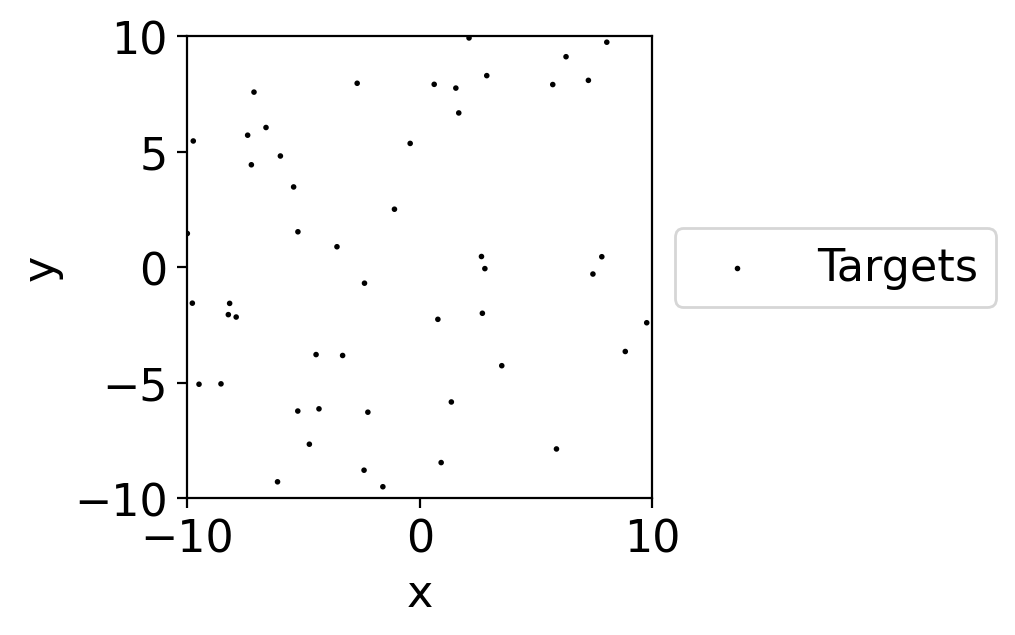

In [7]:
plot_boundary = (10, 10)
num_experiment = 0
ax = None
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

We will use 3 agents in these sims:

- Rando: Uses random Brownian motion search.
- Chemo: Uses only the detected scent gradient to make a decision.
- Info: Estimates how much *information* is encoded in the scent signal to make a decision.

In [8]:
# Agents

# Random search agent
diff = DiffusionGrid(min_length=min_length)
diff.seed(seed_value)

# Run & tumble information
min_length = 1 # Minimum step length on the grid
p_neg = 0.8 # Probability of jumping if gradient/information is decreasing
p_pos = 0.2 # Probabilty of jumping if gradient/information is increasing

# Chemotaxis agent
chemo = GradientDiffusionGrid(
    min_length=min_length,
    p_neg=p_neg,
    p_pos=p_pos,
)
chemo.seed(seed_value)


# Infotaxis agent
threshold = 0.05 # Threshold for information gain
info = GradientInfoGrid(
    min_length=min_length,
    p_neg=p_neg,
    p_pos=p_pos,
    threshold=threshold
)
info.seed(seed_value)



[5838]

Now let's run the experiments.

In [9]:
# Experiments
rand_exp = experiment(
    f"rand",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
info_exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

rand:   0%|          | 0/100 [00:00<?, ?it/s]

chemo:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

Let's plot an example experiment. Here I'm choosing the sixth run for each agent.

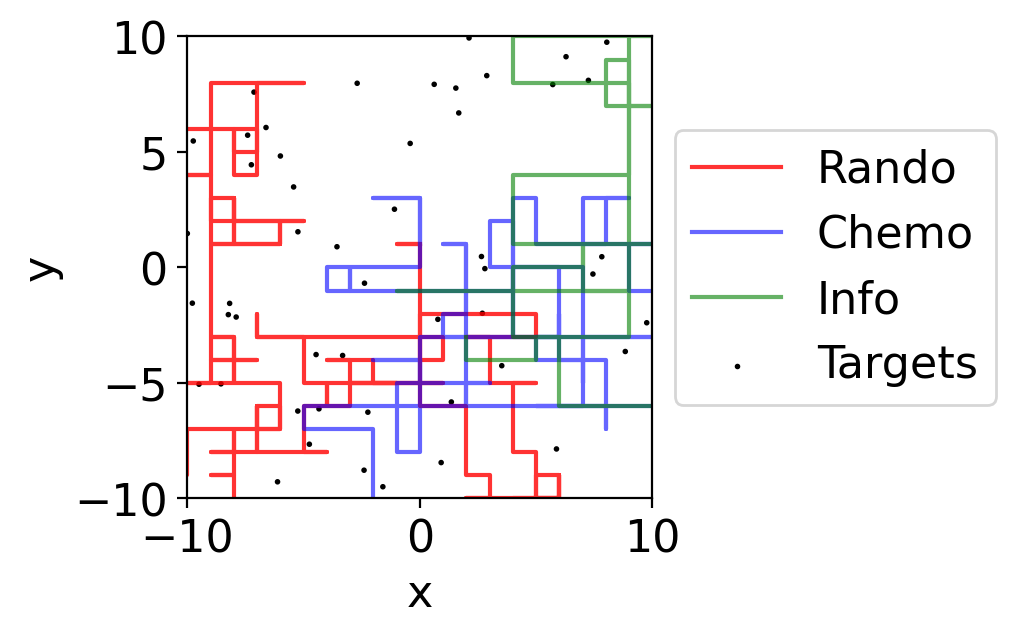

In [10]:
plot_boundary = (10, 10)

# -
num_experiment = 5
ax = None

ax = plot_position2d(
    select_exp(rand_exp, num_experiment),
    boundary=plot_boundary,
    label="Rando",
    color="red",
    alpha=0.8,
    ax=ax,
)
ax = plot_position2d(
    select_exp(chemo_exp, num_experiment),
    boundary=plot_boundary,
    label="Chemo",
    color="blue",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(info_exp, num_experiment),
    boundary=plot_boundary,
    label="Info",
    color="green",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

Hard to distinguish their individual behaviors, but our agents seem to be exploring.

Now let's evaluate some metrics of performance.

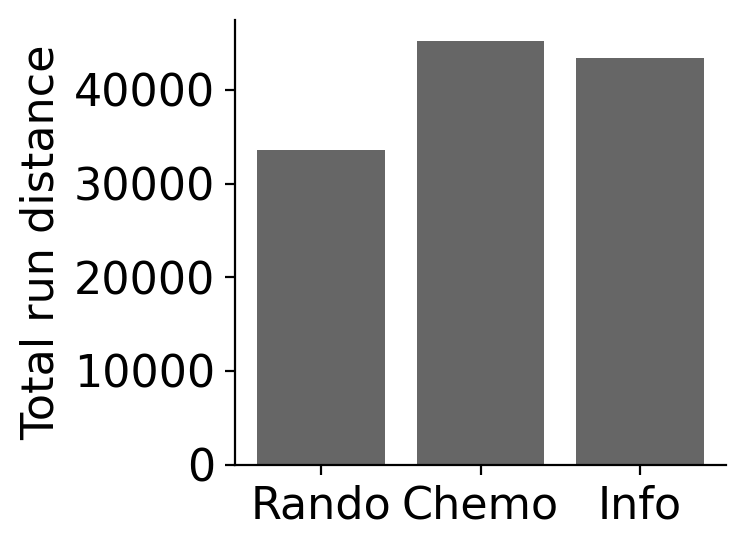

In [11]:
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo", "Info"]
colors = ["red", "blue", "green"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    l = 0.0
    for r in res:
        l += np.sum(r["agent_num_step"])
    scores.append(l)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total run distance")
plt.tight_layout()
sns.despine()

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

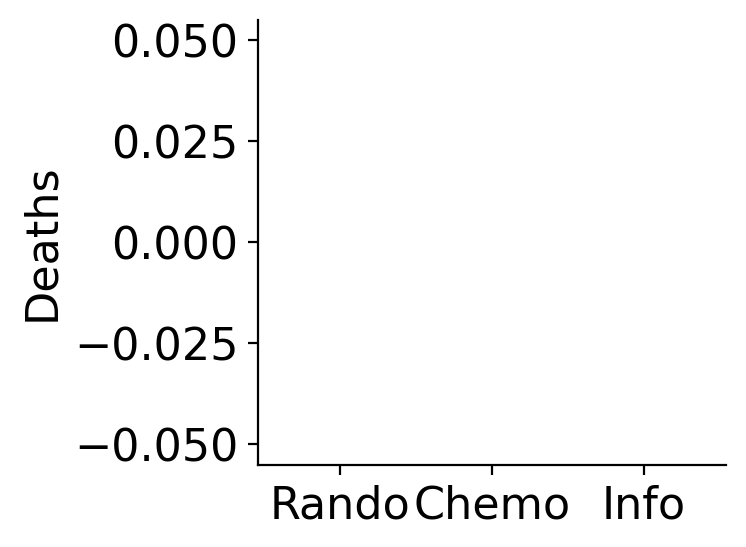

In [16]:
# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))


# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

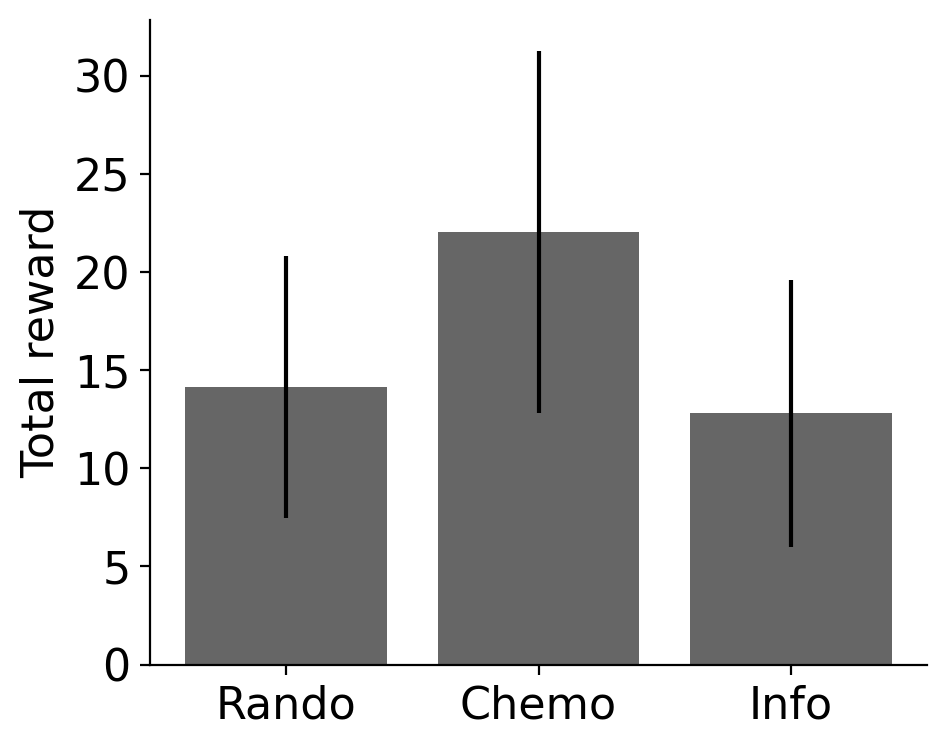

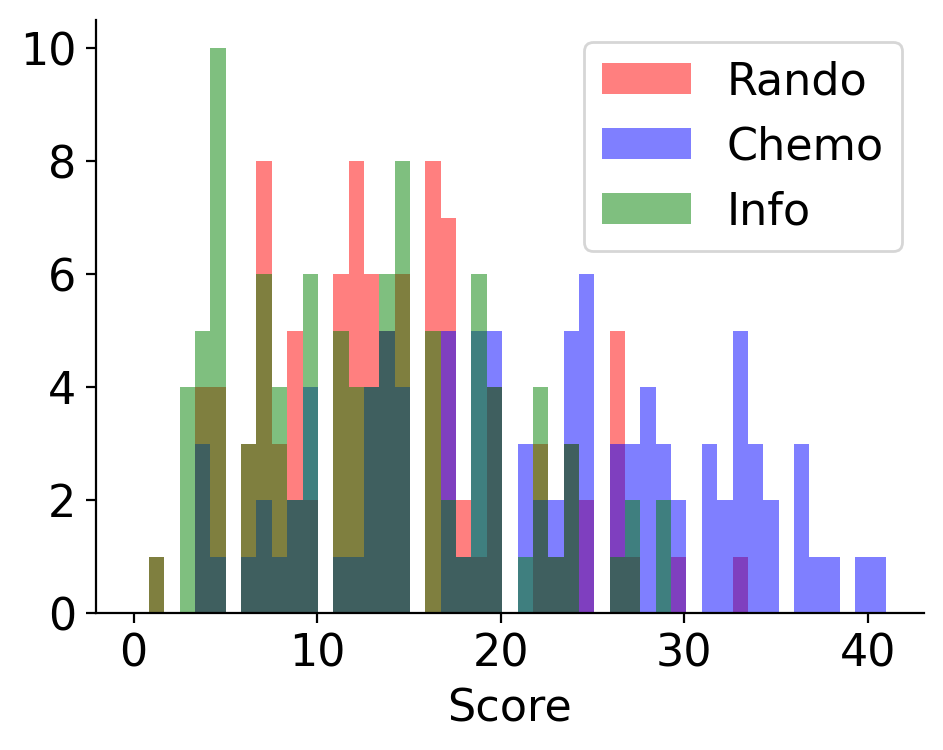

In [17]:
# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

---
### Question 1.1

How does each of our agents perform across the performance measures we have chosen?

__Answer:__

_The chemo and info agents have similar run distances of a little over 40,000 while the rando agent has a smaller run distance of about 35,000. While the total reward was not significantly super different across the agents, it seems that the chemo agent had a slightly higher mean total reward (at about 22) while the rando and info agents' total reward average was lower at about 14 and 13 respectively. For the scores, the chemo agent's scores generally seemed to be higher while the rando agent seemed to be somewhere in between and the info agent's scores seemed to be lower._

---
### Question 1.2

Is having a concept of information (i.e., the Info agent) helpful in these sorts of noisy environments? Why or why not based on how the agents performed? Compare to both Rando and Chemo.

__Answer:__

_The info agent doesn't seem to help in this sort of noisy environment because the info agent's scores are lower than both the rando and the chemo agent, and also the info agent's total reward is lower than that of the chemo agent and similar to (not better than) the rando agent._

## Section 2 - Robustness of information searching

You'll notice that the infotaxis agent has an additional parameter over the simple chemotaxis agent, which is it's threshold. This is needed because, unlike the scent gradient, the information gain (i.e., KL-divergence) gradient is bounded at zero. This determines how much information gain is necessary to trigger a shift.

Here we will test a range of *threshold* values (within the range of values our infotaxis agent is likely to see) and look at the change in performance.

In [18]:
# Our parameters
thresholds = [0.01, 0.025, .05, .075, .09]

# For plotting
colors = ["darkgreen", "seagreen", "cadetblue", "steelblue", "mediumpurple"]
names = thresholds

Let's run these experiments. All of the parameters for the agent and environment (aside from *p_scent*) are specified below.

In [19]:
# Define non-scent probability values
noise_sigma = 1
amplitude = 1
detection_radius = 1
max_steps = 1
min_length = 1
num_targets = 50
target_boundary = (10, 10)

# Define targets
prng = np.random.RandomState(seed_value)
targets = uniform_targets(num_targets, target_boundary, prng=prng)
values = constant_values(targets, 1)

# Scents
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=p_scent, amplitude=amplitude, sigma=noise_sigma)
    scents.append(scent)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

# How many experiments to run
num_experiments = 100

# Infotaxis agent
min_length = 1
p_neg = 0.8
p_pos = 0.2

# Run
results = []

for threshold in thresholds:

  # Setup our agent with a new threshold
  info = GradientInfoGrid(
      min_length=min_length,
      p_neg=p_neg,
      p_pos=p_pos,
      threshold=threshold
  )
  info.seed(seed_value)

  # Run the experiment
  exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
  )
  results.append(exp)


info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

Now let us take a look at the performance. First let's see how the average information gain changes across runs of each experiment (i.e., threshold type). Remember, this is our first agent with a spatial memory and it carries over across runs. So we should see a decreasing trend as the agent learns the environment more.

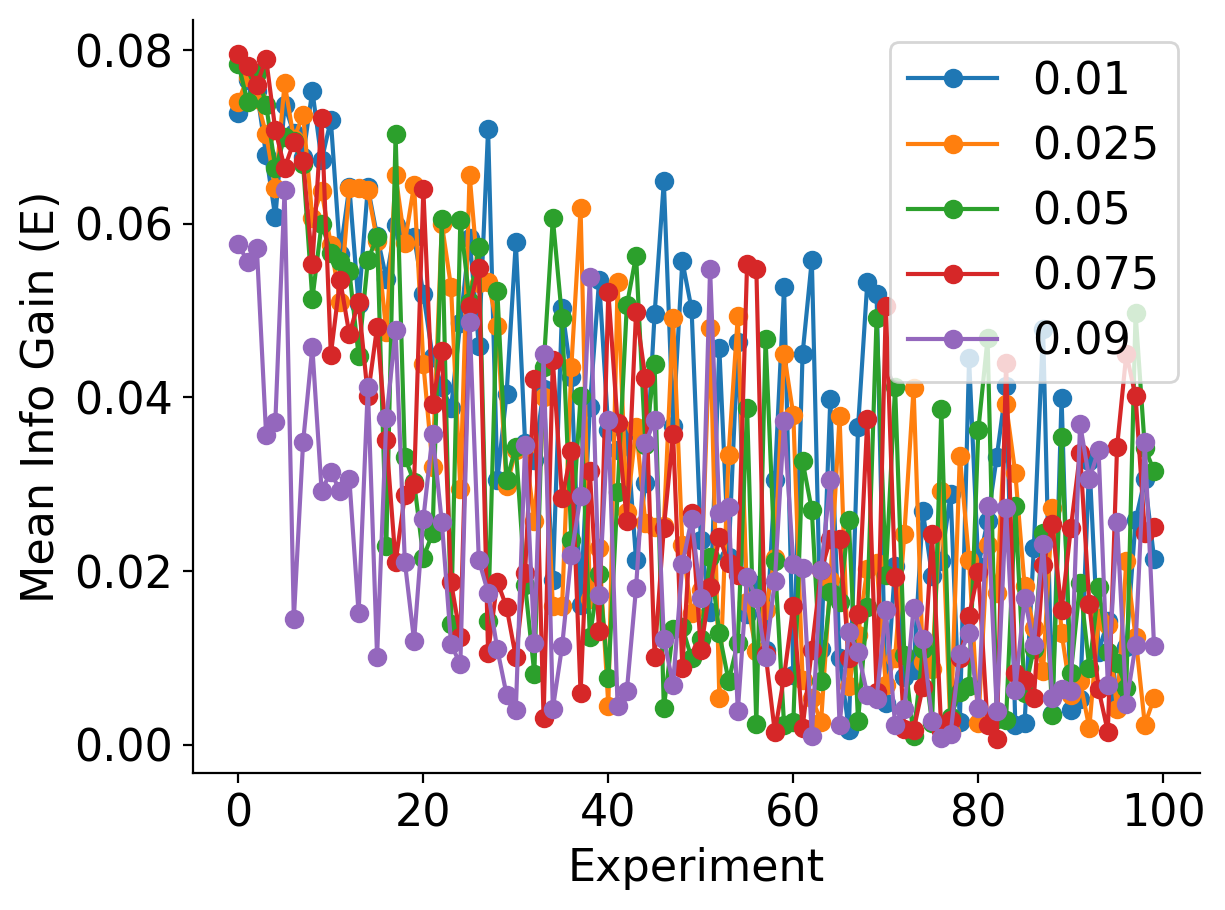

In [20]:
# Score
scores = []
for result in results:
    b = []
    for r in result:
        b.append(np.mean(r["agent_info_gain"]))

    scores.append(b)

steps = np.reshape(scores, (len(thresholds), num_experiments))

# Create the x values for the plot
x = np.arange(len(names))

# Plotting each row of the array as a separate line
for i in range(len(steps)):
    plt.plot(steps[i], marker='o', label=f'{thresholds[i]}')

# Add legend
plt.legend()

plt.ylabel("Mean Info Gain (E)")
plt.xlabel("Experiment")
plt.tight_layout()
sns.despine()

Next we will look at the average performance on a variety of measures as we vary the threshold.

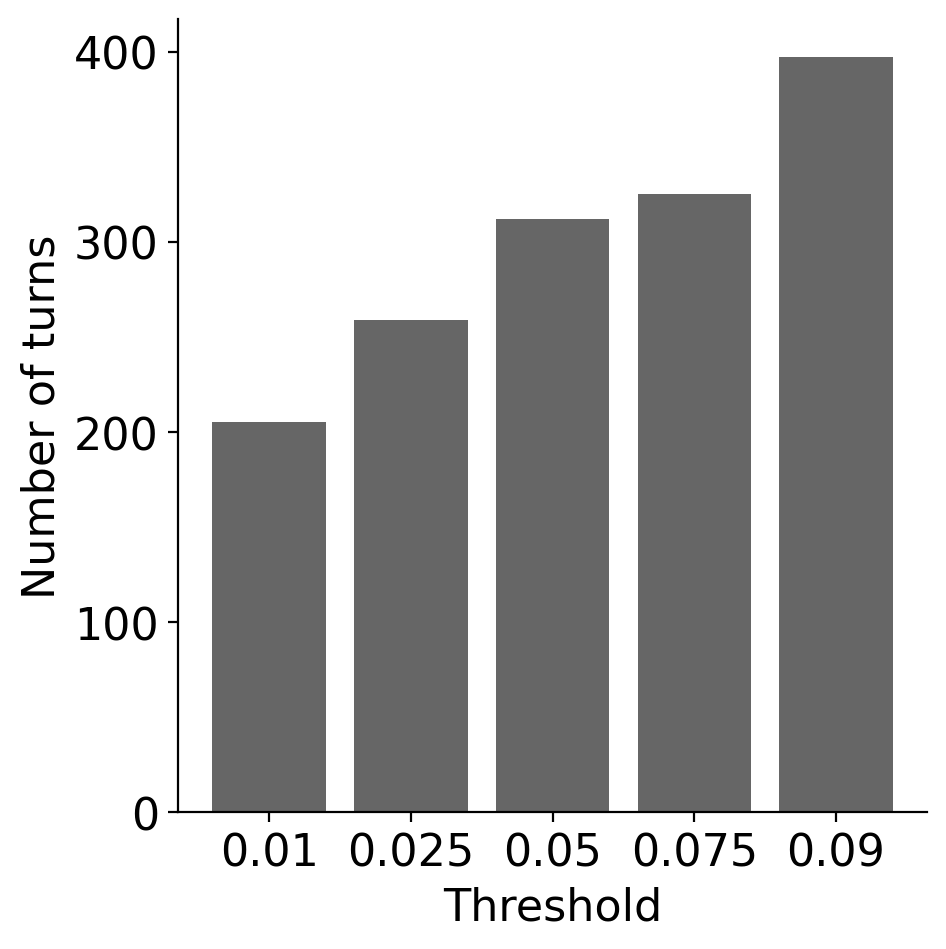

In [21]:
# Score
scores = []
for result in results:
    l = 0.0
    for r in result:
        l += max(r["agent_num_turn"])
    l = l / len(result)
    scores.append(l)

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Number of turns")
plt.xlabel("Threshold")
plt.tight_layout()
sns.despine()

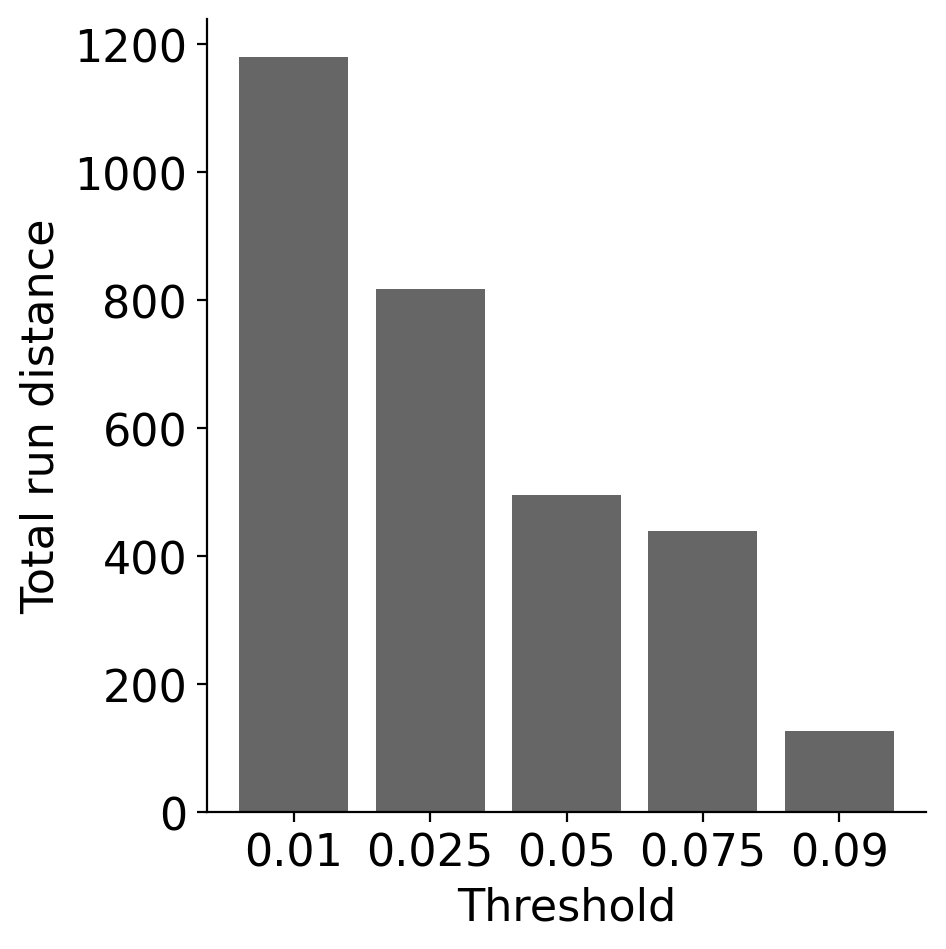

In [22]:
# Score
scores = []
for result in results:
    l = 0.0
    for r in result:
        l += np.sum(r["agent_num_step"])
    l = l / len(result)
    scores.append(l)

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Total run distance")
plt.xlabel("Threshold")
plt.tight_layout()
sns.despine()

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

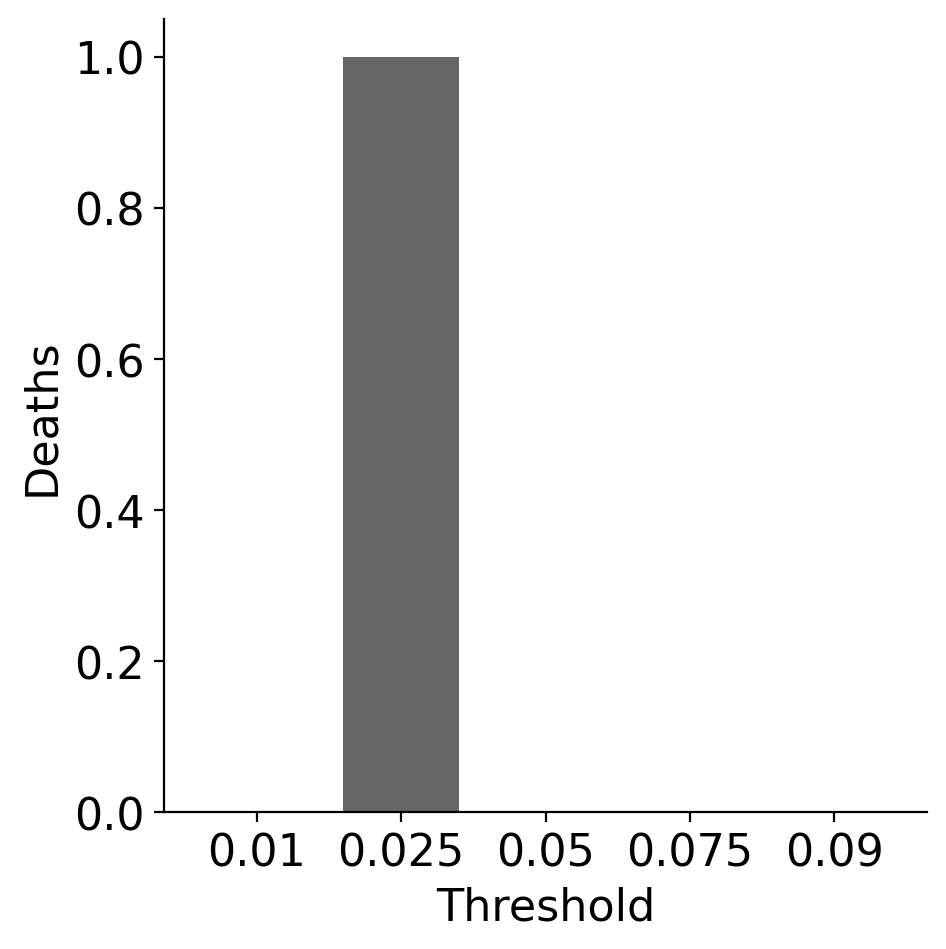

In [23]:
# Score
scores = []
for result in results:
    scores.append(num_death(result))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], scores, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.xlabel("Threshold")
plt.tight_layout()
sns.despine()

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

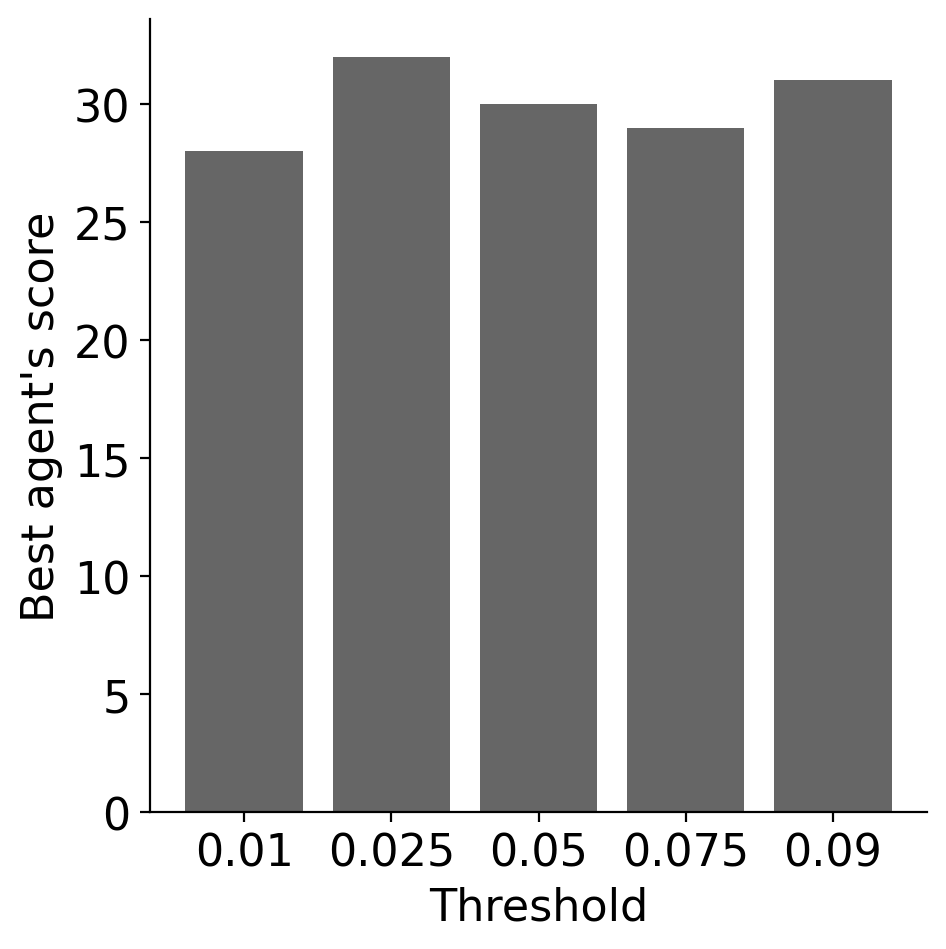

In [24]:
# Max Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)

# Tabulate
m = []
for s in scores:
    m.append(np.max(s))

# -
fig = plt.figure(figsize=(5, 5))
plt.bar([str(n) for n in names], m, color="black", alpha=0.6)
plt.ylabel("Best agent's score")
plt.xlabel("Threshold")
plt.tight_layout()
sns.despine()

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

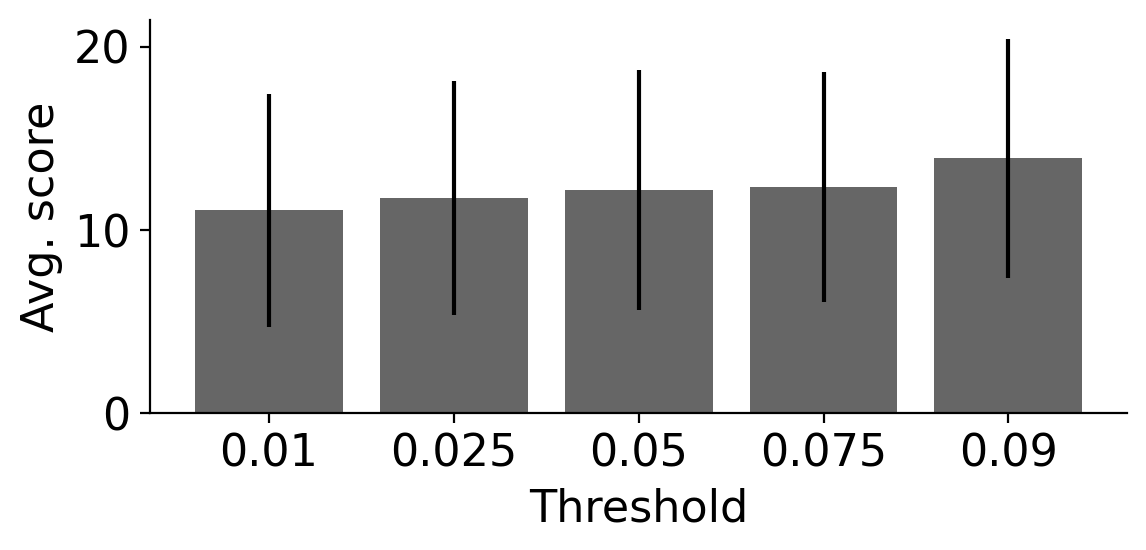

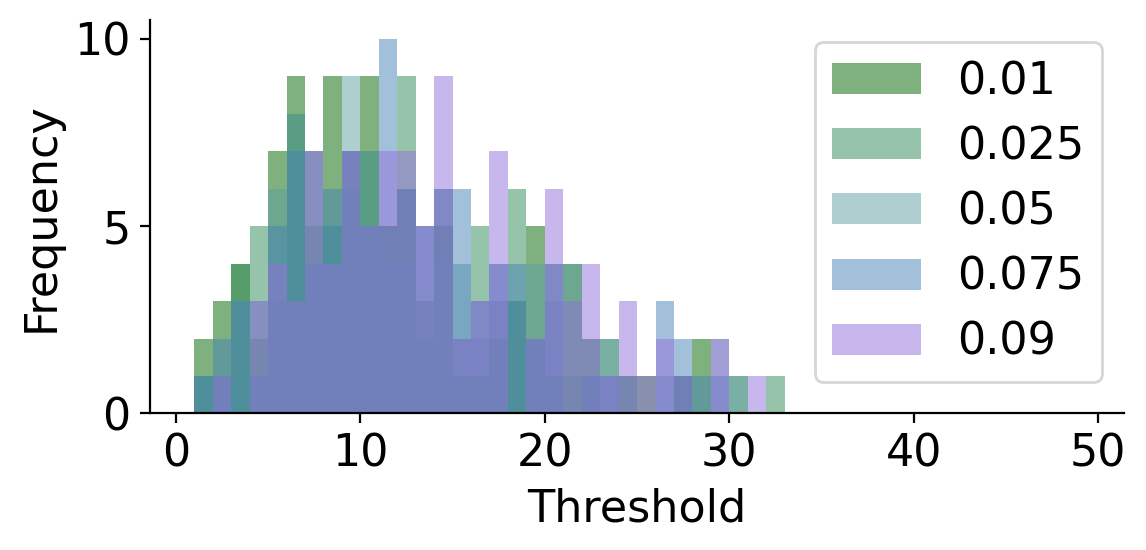

In [25]:
# Score
scores = []
for result in results:
    r = total_reward(result)
    scores.append(r)

# Tabulate
m, sd = [], []
for s in scores:
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(6, 3))
plt.bar([str(n) for n in names], m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Avg. score")
plt.xlabel("Threshold")
plt.tight_layout()
sns.despine()

# Dists of means
fig = plt.figure(figsize=(6, 3))
for (i, s, c) in zip(names, scores, colors):
    plt.hist(s, label=i, color=c, alpha=0.5, bins=list(range(1,50,1)))
    plt.legend()
    plt.ylabel("Frequency")
    plt.xlabel("Threshold")
    plt.tight_layout()
    sns.despine()

---
### Question 2.1

How does increasing the *threshold* impact our Info agent's performance? Explain why this particular pattern emerges in the results.

__Answer:__

_As the threshold increases, the run distance decreases while the number of deaths and best agent's score generally stays the same across thresholds. The average score also generally stays the same across thresholds. The decrease in run distance pushes the info agent closer to rando agent (as demonstrated by shorter run distance). This is because when the threshold increases, it's harder to make a decision and thus the agent is likelier to tumble._

---
### Question 2.2

Take the results from the two sections together. Compare the infotaxis agent with the random search or chemotaxis agent. What does this tell you about the nature of curious search?

__Answer:__

_The infotaxis agent is really similar to rando agent (and also chemo agent in some ways, as decribed in previous questions), which suggests that curious search is very similar to and based on searches like random search (or chemo). Rando and chemo are like starting points for curious search and so it's similar._


---
**IMPORTANT** Did you collaborate with anyone on this assignment, or use LLMs like ChatGPT? If so, list their names here.
> *Write Name(s) here*